<a href="https://colab.research.google.com/github/hoeksemaa/neural_signal_processing/blob/main/notebooks/CodingLab1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_Neural Data Analysis_

Lecturer: Prof. Dr. Philipp Berens

Tutors: Sarah Strauss, Ziwei Huang

Summer term 2021

Due date: 2021-04-26, 9am

Student names: *FILL IN YOUR NAMES HERE*

# Coding Lab 1

Download the data file ```nda_ex1.csv``` from ILIAS and save it in a subfolder ```../data/```.

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from sklearn.decomposition import PCA
import scipy as sp
import itertools as it
sns.set_style('whitegrid')
%matplotlib inline

## Load data

The recording contains extracellular recordings from 4 channels. Details of the experimental procedure were given during the lecture.

In [ ]:
Fs = 30000     # sampling rate of the signal in Hz
dt = 1/Fs
gain = .5      # gain of the signal
x = pd.read_csv('./data/nda_ex_1.csv', header=0, names=('Ch1', 'Ch2', 'Ch3', 'Ch4'))

In [ ]:
x.describe()

,Ch1,Ch2,Ch3,Ch4
count,675799.000000,675799.000000,675799.000000,675799.000000
mean,-32.100403,-38.072332,-41.601624,-32.636265
std,390.010478,409.742050,434.222388,411.430570
min,-2949.000000,-3128.000000,-3178.000000,-3200.000000
25%,-218.000000,-233.000000,-236.000000,-224.000000
50%,-10.000000,-13.000000,-13.000000,-9.000000
75%,202.000000,205.000000,212.000000,207.000000
max,1566.000000,1597.000000,1732.000000,1589.000000


## Task 1: Filter Signal

In order to detect action potentials, the first step is to filter out low frequency fluctuations (LFP) and high frequency noise. Determine appropriate filter settings and implement the filtering in the function ```filterSignal()```. A typical choice for this task would be a butterworth filter. Plot a segment of the raw signal and the filtered signal for all four channels with matching y-axis. The segment you choose should contain spikes. When you apply the function also test different filter settings. Hint: Make sure to use a filter that compensates for phase shifting.

*Grading: 2 pts*


In [ ]:
def filterSignal(x, Fs, low, high):
    # Define order of the filter
    order = 2

    # Define the frequency band
    nyquist = 0.5 * Fs
    low = low / nyquist
    high = high / nyquist

    # Design Butterworth bandpass filter
    b, a = signal.butter(order, [low, high], btype='band')

    # Apply the filter
    y = pd.DataFrame()
    # ran into issue where the last value of columns Ch2, Ch3, Ch4 were NaN value
    # signal.filtfilt apparently doesn't handle NaN values well
    for column in x:
        col_data = x[column]

        # Check for NaN values and handle them accordingly
        if col_data.isnull().any():
            # Interpolate NaN values or fill with some value
            # Here we use interpolation, but make sure this is appropriate for your data
            col_data = col_data.interpolate(method='linear', limit_direction='both')

            # If the last value is NaN, replace it with the previous one
            if np.isnan(col_data.iloc[-1]):
                col_data.iloc[-1] = col_data.iloc[-2]

        y[column] = signal.filtfilt(b, a, col_data)

    return y

In [ ]:
xf = filterSignal(x, Fs, 500, 4000)

In [ ]:
#for column in x:
#  print(x[column].head())
#  print(x[column].tail())

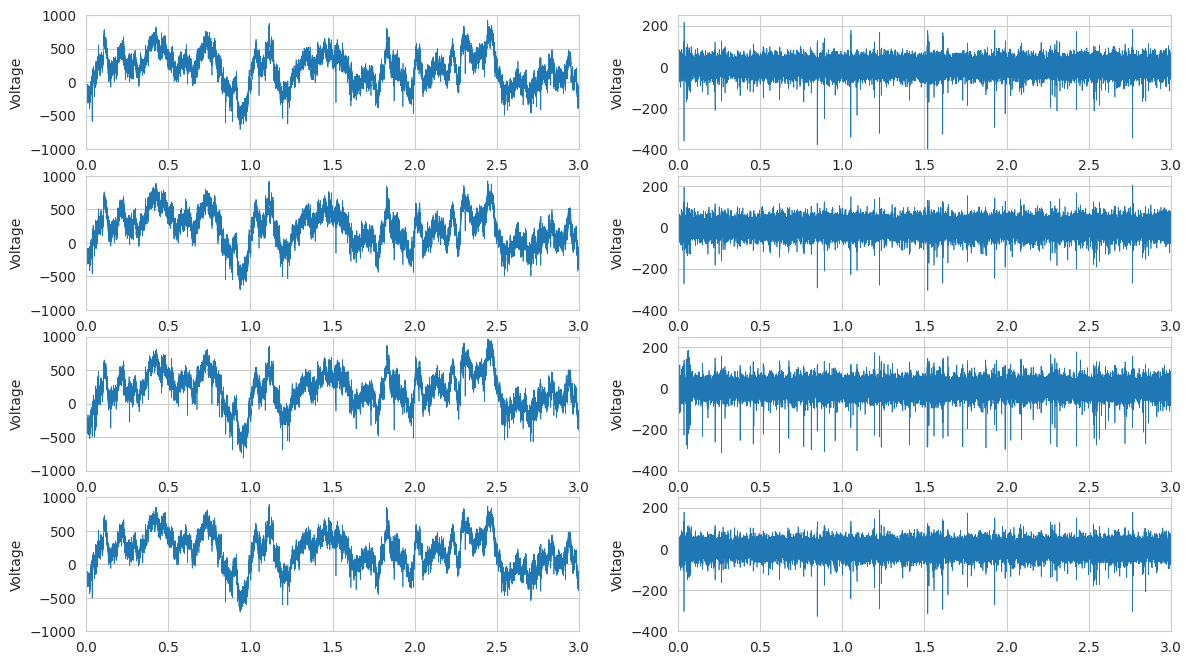

In [ ]:
plt.figure(figsize=(14, 8))

T = 100000
t = np.arange(0,T) * dt

for i, col in enumerate(xf):
    plt.subplot(4,2,2*i+1)
    plt.plot(t,x[col][0:T],linewidth=.5)
    plt.ylim((-1000, 1000))
    plt.xlim((0,3))
    plt.ylabel('Voltage')


    plt.subplot(4,2,2*i+2)
    plt.plot(t,xf[col][0:T],linewidth=.5)
    plt.ylim((-400, 250))
    plt.xlim((0,3))
    plt.ylabel('Voltage')


## Task 2: Detect action potentials

Action potentials are usually detected by finding large-amplitude deflections in the continuous signal. A good choice of threshold for detecting spikes is important. If it is too low, you will detect too many low amplitude events (noise); if it is too high, you run the risk of missing good spikes. Implement an automatic procedure to obtain a reasonable threshold and detect the times when spikes occurred in the function ```detectSpikes()``` . Plot a segment of the filtered signal for all four channels with matching y-axis and indicate the time points where you detected spikes. Plot the threshold. Are the detected time points well aligned with peaks in the signal? Hint: Pay attention to the sign of the signal, what does it mean that it's an extracellular recording?

*Grading: 3 pts*

In [ ]:
def robust_std_dev(column):
    median_val = np.median(column)
    mad = np.median(np.abs(column - median_val) / 0.6745 )
    return mad

def check_adjacent_values(column):
    # Initialize a list to store the boolean results
    results = []

    # Iterate over the column starting from the second element and ending at the second-to-last element
    for i in range(1, len(column) - 1):
        # Check the condition for the current element
        condition = column[i] <= column[i-1] and column[i] <= column[i+1]

        # Append the result to the list
        if condition:
            results.append(i)

    # Return the list of boolean results
    return results

def detectSpikes(x,Fs):
# Detect spikes
# s, t = detectSpikes(x,Fs) detects spikes in x, where Fs the sampling
#   rate (in Hz). The outputs s and t are column vectors of spike times in
#   samples and ms, respectively. By convention the time of the zeroth
#   sample is 0 ms.
    s = []
    t = []
    dt = 1/Fs

    for i in range(x.shape[1]):
        column = x[:, i]
        std_dev = robust_std_dev(column)
        threshold = -std_dev * 3.5
        lowest_points = check_adjacent_values(column)
        indices = np.where((column < threshold) & np.isin(np.arange(len(column)), lowest_points))[0].tolist()
        s.append(indices)
        t.append([i * dt for i in indices])

    return (s, t)


In [ ]:
T = xf.shape[0]
s, t = detectSpikes(xf.values,Fs)

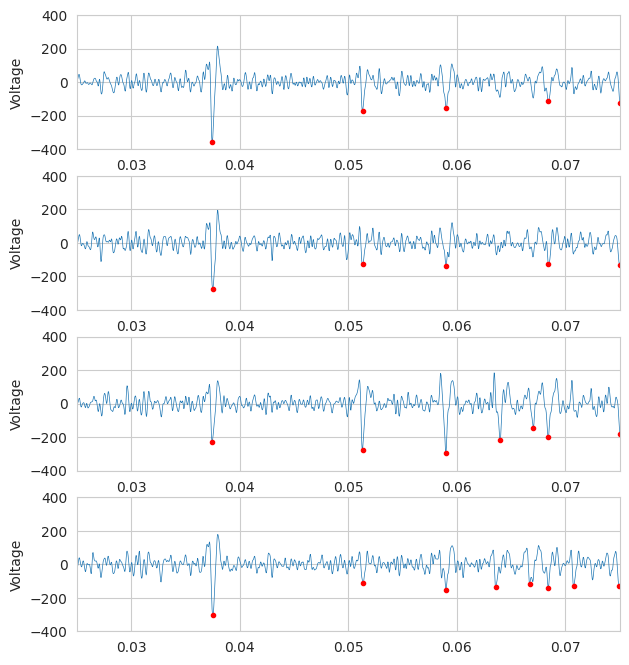

In [ ]:
plt.figure(figsize=(7, 8))

tt = np.arange(0,T) * dt

for i, col in enumerate(xf):
    plt.subplot(4,1,i+1)
    plt.plot(tt,xf[col],linewidth=.5)
    plt.plot(tt[s[i]],xf[col][s[i]],'r.')
    plt.ylim((-400, 400))
    plt.xlim((0.025,0.075))
    plt.ylabel('Voltage')

## Task 3: Extract waveforms
For later spike sorting we need the waveforms of all detected spikes. Extract the waveforms segments (1 ms) on all four channels for each spike time (as a result each spike is represented by a 4x30 element matrix). Implement this procedure in the function ```extractWaveforms()```. Plot (a) the first 100 spikes you detected and (b) the 100 largest spikes you detected. Are there a lot of very small spikes (likely noise) among your detected spikes? If so your threshold may be too low. Can you see obvious artifacts, not looking like spikes at all?

*Grading: 2 pts*

In [21]:
def extractWaveforms(x, s, dt):
# Extract spike waveforms.
#   w = extractWaveforms(x, s) extracts the waveforms at times s (given in
#   samples) from the filtered signal x using a fixed window around the
#   times of the spikes. The return value w is a 3d array of size
#   length(window) x #spikes x #channels.

    for i in range(len(s)):
      # for my puny brain, i'm going to spell out variable progressions explicitly
      # "i" will cycle through 0, 1, 2, 3
      # it indicates the row of neural spike data out of 4 rows in s
      #
      # "i" holds the column of x fixed while the spike_index creates the index range of neural data to draw from x
      # columns of x are the same as rows of s: sequential lists of neural data from a single recorder
      head_offset = 10 #round(10 / dt / 1000)
      tail_offset = 20 #round(20 / dt / 1000)
      spike_indices = s[i]
      last_index = len(x[:, i])
      spike_indices = [index for index in spike_indices if head_offset <= index <= (last_index - tail_offset)]
      ###print(tail_offset)
      ###print(s[i][-1])
      ###print(len(x[:, 0]))
      # there's a problem with some spikes being too close to the end index of x that they can't be properly sliced
      # just gonna filter out those that are too close
      waveforms = np.array([x[spike_index - head_offset: spike_index + tail_offset, i] for spike_index in spike_indices])
      # truncate number of spikes to maintain uniformity in data dimensions
      # 5000 is relatively arbitrary cutoff
      # dimension with the lowest number of detected spikes has >6000
      waveforms = waveforms[:5000, :]

      # expand to 3d
      waveforms = np.expand_dims(waveforms, axis=0)

      # if waveforms array is the first to be processed, initialize it as the base 3d numpy array
      # otherwise, stack it with the base array
      if i == 0:
        all_channels = waveforms
      else:
        all_channels = np.concatenate((all_channels, waveforms), axis=0)
      ##########numpy_waveforms = np.vstack(waveforms)
      #for j in range(len(waveforms)):
        #if j < 5:
          #print(s[0][j])
          #print(j)
          #print(waveforms[i])
      #######for w in waveforms:
        ####print(w)
        #######print(type(w))
      ########w.append(waveforms)
    #########w = np.array(w)
    return all_channels

# THERE ARE DIFFERENT NUMBERS OF SPIKES PER ROW OF NEURAL DATA BUT THE DIMENSIONS (# SPIKES) HAVE TO MATCH ANYWAYS
# will arbitrarily set to 5000 spikes for now

In [ ]:
#for i in range(len(s)):
#  print(s[i][0])
#  print(s[i][-1])
#  print(len(x.values[:, 0]))
#  print()

In [22]:
w = extractWaveforms(xf.values, s, dt)
w.shape

(4, 5000, 30)

Plot first 100 spike waveforms, include 10 ms before the peak, and 20 ms after.

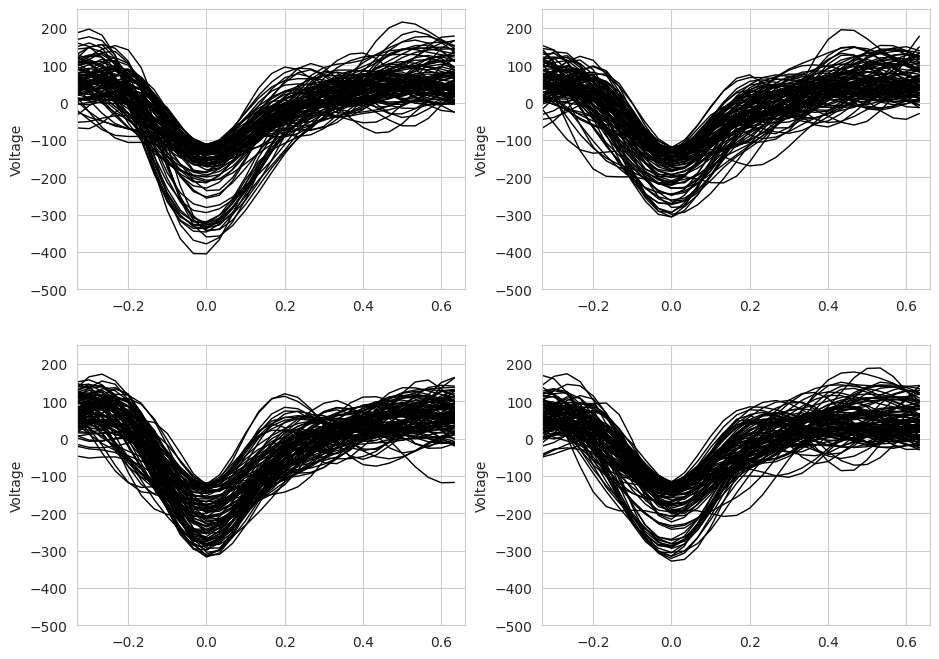

In [23]:
t = np.arange(-10,20) * dt * 1000
how_many = 100

plt.figure(figsize=(11, 8))

for i, col in enumerate(xf):
    plt.subplot(2,2,i+1)
    for j in range(how_many):
      plt.plot(t,w[i,j,:],'k', linewidth=1)
    plt.ylim((-500, 250))
    plt.xlim((-0.33,0.66))
    plt.ylabel('Voltage')


Plot largest 100 spike waveforms, include 10 ms before the peak, and 20 ms after.

[[3853  560  471 ... 1858 3169 1317]
 [3444  530 3448 ... 1128 1155 1847]
 [ 576 4776  687 ... 4762 1219 3293]
 [3934 3926  588 ...  747 1814 3690]]
(4, 5000)


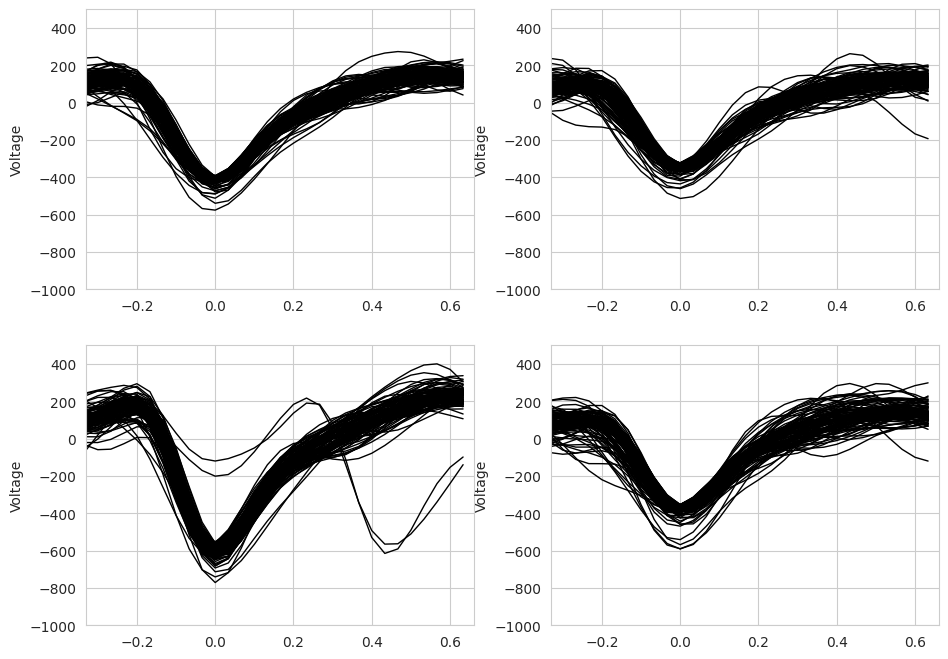

In [34]:
lowest_value_for_spike = np.min(w, axis=2)
idx = np.argsort(lowest_value_for_spike, axis=1)
print(idx)
print(idx.shape)

t = np.arange(-10,20) * dt * 1000

how_many = 100

plt.figure(figsize=(11, 8))
for i, col in enumerate(xf):
    plt.subplot(2,2,i+1)
    for j in range(how_many):
      #plt.plot(t,w[:,idx[0:100],i],'k', linewidth=1)
      plt.plot(t,w[i, idx[i, j], :],'k', linewidth=1)
      #plt.plot(t,w[i, j, :],'k', linewidth=1)
    plt.ylim((-1000, 500))
    plt.xlim((-0.33,0.66))
    plt.ylabel('Voltage')

## Task 4: Extract features using PCA
Compute the first three PCA features on each channel separately in ```extractFeatures()```. You can use a available PCA implementation or implement it yourself. After that, each spike is represented by a 12 element vector. Compute the fraction of variance captured by these three PCs.
Plot scatter plots for all pairwise combinations of 1st PCs. Do you see clusters visually?

*Grading: 2+1 pts*


In [ ]:
def extractFeatures(w):
# Extract features for spike sorting.
#   b = extractFeatures(w) extracts features for spike sorting from the
#   waveforms in w, which is a 3d array of size length(window) x #spikes x
#   #channels. The output b is a matrix of size #spikes x #features.
#   The implementation should do PCA on the waveforms of each channel
#   separately and uses the first three principal components. Thus, we get
#   a total of 12 features. Also, the varianced explained by the 3 features per channel
#   should be computed.




    return b



In [ ]:
b = extractFeatures(w)

In [ ]:
plt.figure(figsize=(10, 6))
plt.suptitle('Scatter plots',fontsize=20)

idx = [0, 3, 6, 9]
p = 1
labels = ['Ch1','Ch2','Ch3','Ch4']
for i in np.arange(0,4):
    for j in np.arange(i+1,4):
        ax = plt.subplot(2,3,p, aspect='equal')
        plt.plot(b[:,idx[i]],b[:,idx[j]],'.k', markersize=.7)
        plt.xlabel(labels[i])
        plt.ylabel(labels[j])
        plt.xlim((-1500,1500))
        plt.ylim((-1500,1500))
        ax.set_xticks([])
        ax.set_yticks([])
        p = p+1

In [ ]:
np.save('../data/nda_ex_1_features',b)
np.save('../data/nda_ex_1_spiketimes',s)
np.save('../data/nda_ex_1_waveforms',w)